## FC GCG Verfahren

Zuerst werden die nötigen Pakete für das Verfahren importiert.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

Zunächst werden die Dimensionen der betrachteten Matrizen festgelegt, um im Anschluss alle notwenigen Werte für die
Problemstellung zu generieren.

In [2]:
m = 23
n = 21
N = 19

Für die Problemstellung selbst werden Matrizen $K_1,\dots,K_N\in\mathbb{R}^{m\times n}$ benötigt. Damit lineare Konvergenz des Verfahren gegeben ist, muss der Operator $\mathcal{K}\cdot=\sum_{j=1}^NK_j\cdot$ injektiv sein. Für den Operator bedeutet das, dass $\sum_{j=1}^{N}K_j$ vollen Spaltenrang besitzt. Der Operator wird also wie folgt definiert:

In [3]:
np.random.seed(43) # Festlegung eines Seeds, bei dem der Operator tatsächlich injektiv ist. 

K_matrices = [np.random.rand(m, n) for _ in range(N)]

Der folgende Code stellt sicher, dass $\mathcal{K}$ injektiv ist, d.h. dass $\sum_{j=1}^{19}K_j$ vollen (Spalten-)Rang besitzt.

In [4]:
# Summe der Matrizen berechnen
#K_sum = sum(K_matrices)

# Überprüfen, ob die Summenmatrix K_sum injektiv ist
#is_injective = np.linalg.matrix_rank(K_sum) == n

#print(f"Rang der Summenmatrix: {np.linalg.matrix_rank(K_sum)}")
#print(f"Die Abbildung ist {'injektiv' if is_injective else 'nicht injektiv'}")

Dann wird noch ein Vektor $y_d\in\mathbb{R}^m$ benötigt, der die gemessenen Daten darstellt. Auch dieser wird aus dem oben erstellten Seed generiert.

In [5]:
np.random.seed(42)

y_d = np.array(np.random.rand(m))

In [6]:
def F(x):
    norm = x - y_d
    val = 1/2*cp.norm(norm, 2)**2
    return val

In [7]:
def nablaF(x):
    return x-y_d

Damit der Regularisierungsfaktor $\alpha$ global verwendet werden kann, wird er einmalig $\textbf{vor}$ G definiert

In [18]:
alpha = 0.1

In [8]:
def G(x):
    G = 0
    for j in range(0,N-1):
        G += np.linalg.norm(x[:,j])
    return alpha*G

In [9]:
def K(x):
    val = np.zeros(m)
    K = K_matrices
    for j in range(0,N-1):
        val = val + K[j]@x[:,j]
    return np.array(val)

Damit die duale variable $p_k$ berechnet werden kann muss noch der duale Operator $\mathcal{K}^*$ initialisiert werden.

In [10]:
def K_dual(x):
    return np.column_stack([K.T@x for K in K_matrices])

In [17]:
def FCGCG(F, DF, alpha, G, K, K_dual, maxiter, eps_abstol, eps_trace):
    # Definiere Startwerte für die Ausführung des Algorithmus
    N_k = 1
    lambda_op = [0]
    u_k = [np.zeros((n,N))]
    
    # Erstelle Listen, die die Werte F(Ku_k)+G(u_k) und die in jeder Iteration gewählte Spalte j_star enthalten
    vals = []
    # Setze Iterationszähler auf 0
    k = 0
    
    while True: 
        # Berechne u und p_k
        u = np.zeros((n,N))
        for i in range(N_k):
            u = u + lambda_op[i]*u_k[i]
        p_k = -K_dual(DF(K(u)))
        p_norms = np.array([np.linalg.norm(p_k[:,i]) for i in range(0,N)])
        
        traces.append(np.trace(p_k.T@u)-sum(lambda_op))
        # Ermittle Index der maximalen Spaltennorm von p_k 
        j_star = np.argmax(p_norms)
        js.append(j_star)
        
        # Berechne F(Ku_k) + G(u_k) für aktuelle die aktuelle Iterierte 
        vals.append(1/2*np.linalg.norm(K(u)-y_d)**2+G(u))
        
        # Berechne v_k
        v_k = np.zeros((n,N))
        v_k[:,j_star] = p_k[:,j_star] * 1/(alpha*np.linalg.norm(p_k[:,j_star]))
        u_k.append(v_k)
        
        if np.abs(1-np.trace(p_k.T@v_k)) < eps_trace and k >= 1: # Abbruchbedingung
            break
        
        # Aktualisiere die Länge von u_k in neuem vorübergehenden Parameter
        N_k_plus = len(u_k)
        
        ## Ermittle mithilfe vpn cvxpy den optimalen Vektor \lambda\in R^{N_k_plus}
        # Initialisierung des Problems in cvxpy-Form
        lambda_var = cp.Variable(N_k_plus)
        inputF = cp.sum([lambda_var[i] * K(u_k[i]) for i in range(N_k_plus)])
        
        # Definiere nicht-Negativität als Nebenbedingung^
        constraint = [lambda_var >= 0]
        objective = cp.Minimize(F(inputF) + cp.sum(lambda_var))
        
        # Definition und Lösung des Problems
        problem = cp.Problem(objective, constraint)
        problem.solve(solver = 'ECOS', abstol = eps_abstol)
        lambda_op = []
        # Vektor lambda als Lösung des Teilproblems für die Berechnung von u_k+1
        lambda_op = lambda_var.value
        
        # Ermittlung derjenigen Einträge u_k[j], für die lambda_op[j] Werte kleiner als 10^{-12} annimmt
        zeros = np.where(np.array(lambda_op) < 1e-8)[0]
        
        if len(zeros) > 0:
            for j in sorted(zeros, reverse=True):
                # Löschung der Einträge aus u_k und lambda_op
                del u_k[j]
                lambda_op = np.delete(lambda_op, j)
        
        k += 1
        N_k = len(u_k)
        
        if k == maxiter:
            break
        
    return u, vals, u_k

In [19]:
u, vals, u_k = FCGCG(F, nablaF, alpha, G, K, K_dual, 500, 1e-10, 1e-7)

u_opt, vals_opt, us_opt= FCGCG(F, nablaF, alpha, G, K, K_dual, 500, 1e-18, 1e-9)

C:\Users\Eric\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:354: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add an explicit dependency on ECOS or switch to our new
    default solver, Clarabel, by either not specifying a solver argument
    or specifying ``solver=cp.CLARABEL``.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)
C:\Users\Eric\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [15]:
p = -K_dual(nablaF(K(u)))
norm = np.array([np.linalg.norm(p[:,i]) for i in range(0,N)])
jmax = np.argmax(norm)

v = np.zeros((n,N))
v[:,jmax] = p[:,jmax] * 1 / (alpha*np.linalg.norm(p[:,jmax]))

p_opt = -K_dual(nablaF(K(u_opt)))
norm_opt = np.array([np.linalg.norm(p_opt[:,i]) for i in range(0,N)])
jmax_opt = np.argmax(norm_opt)

v_opt = np.zeros((n,N))
v_opt[:,jmax_opt] = p_opt[:,jmax_opt] * 1 / (alpha*np.linalg.norm(p_opt[:,jmax_opt]))

print(f"", 1-np.trace(p.T@v), np.trace(p.T@u)-G(u), len(vals), vals[-1])
print(f"", 1-np.trace(p_opt.T@v_opt), np.trace(p_opt.T@u_opt)-G(u_opt), len(vals_opt), min(vals_opt))

 -7.436134152882801e-08 -2.7108436467804253e-08 244 0.09085287751524156
 -4.171929468554936e-11 -2.711868923865879e-10 326 0.09085287238082869


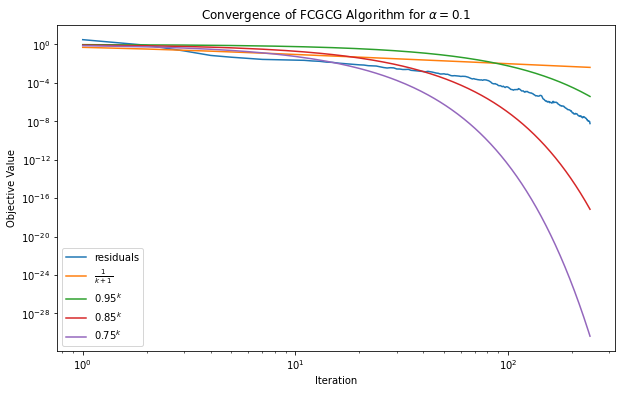

In [16]:
k = np.array([k for k in range(1,len(vals))])
optval = vals_opt[-1]
resids = [vals[k-1]-optval for k in k]
resids = np.abs(resids)

convk = [1/(k+1) for k in k]

k95 = 0.95 ** k
k85 = 0.85 ** k
k75 = 0.75 ** k

plt.figure(figsize=(10, 6))

plt.plot(k, resids, label = "residuals")
plt.plot(k, convk, label = "$\\frac{1}{k+1}$")
plt.plot(k, k95, label = "$0.95^k$")
plt.plot(k, k85, label = "$0.85^k$")
plt.plot(k, k75, label = "$0.75^k$")

plt.xlabel('Iteration')
plt.ylabel('Objective Value')

plt.yscale('log')
plt.xscale('log')

plt.title(f'Convergence of FCGCG Algorithm for $\\alpha = {alpha}$')
plt.legend()

plt.savefig(f"new new final superlinear convergence alph = {alpha}.png", dpi=200)

plt.show()

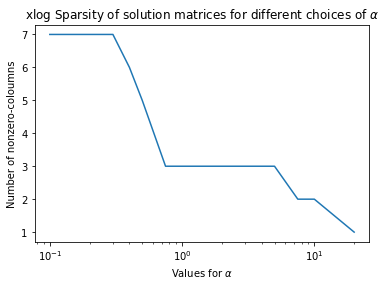

In [22]:
# Showing number of nonzero coloumns for different choices of alpha

alphas = [0.1, 0.25, 0.3, 0.4, 0.5, 0.75, 1.0, 1.5, 2.5, 3.0, 4.5, 5.0, 7.5, 10.0, 20.0]
nonzeros = []
for alph in alphas:
    u_alph = FCGCG(F, nablaF, alph, G, K, K_dual, 500, 1e-9, 1e-9)[0]
    nonzero = np.where(u_alph[0] < 1e-10)[0]
    nonzeros.append(N-len(nonzero))

plt.plot(alphas, nonzeros)
plt.xlabel("Values for $\\alpha$")
plt.xscale('log')
#plt.yscale('log')
plt.ylabel("Number of nonzero-coloumns")
plt.title("xlog Sparsity of solution matrices for different choices of $\\alpha$")
plt.savefig(f"sparsity of solutions.png", dpi=200)
plt.show()